## Cleaning Data (API Called) 6950 data points

In [1]:
#import visualization tools for subsequent analysis
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

df = pd.read_csv('movieDB_API_movies.csv') # read in original csv
df = df.drop(columns='Unnamed: 0') # drop useless column index-like column

## Create Metric Columns
# We have many rows with no budget or revenue. We want to filter them out and create a new 'Profit' column
df['gross_profit'] = round(df[(df['revenue'] != 0) & (df['budget'] != 0)]['revenue'] -df[(df['revenue'] != 0) & (df['budget'] != 0)]['budget'],2)
# Create profit margin column , ROI, with complete dataframe
df['ROI (%)'] = round((df['gross_profit'] / df['budget']) * 100,2)

## Empty rows
# there are 2677 with null gross_profit, we want to
df_profits = df[df['gross_profit'].notna()]

# pd.DataFrame(df_profits).to_csv('movieDB_API_movies_w_gross_profits_&_ROI.csv') #Turn into csv file for easy access

In [2]:
df_profits.head() # this is what our data looks like

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%)
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0,657.58
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0,13.37
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0,3984.44
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0,1669.38
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0,1360.75


In [3]:
df_profits.info() # 6950 no missing data apparently, 4273/6950 have gross_profit (61% of data can use profit metric)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4273 entries, 0 to 6949
Data columns (total 13 columns):
budget          4273 non-null int64
genres          4273 non-null object
id              4273 non-null int64
imdb_id         4273 non-null object
popularity      4273 non-null float64
release_date    4273 non-null object
revenue         4273 non-null int64
runtime         4271 non-null float64
title           4273 non-null object
vote_average    4273 non-null float64
vote_count      4273 non-null int64
gross_profit    4273 non-null float64
ROI (%)         4273 non-null float64
dtypes: float64(5), int64(4), object(4)
memory usage: 467.4+ KB


## What are the genres?

In [4]:
#showing first ten genres
df_profits['genres'].value_counts()[0:10] #we should keep the combinations... They're important

### MY ANALYSIS
# What genres do we have?
## 1625 unique combinations of genres

# Top 3 Genres?
## Comedy 552/1625 or 34%
## Drama 419/1625 or 26%
## (Drama + Romance) 195/1625 or 12%

['Comedy']                        237
['Drama']                         234
['Drama', 'Romance']              114
['Comedy', 'Romance']             106
['Horror', 'Thriller']             91
['Comedy', 'Drama']                85
['Comedy', 'Drama', 'Romance']     79
['Horror']                         69
['Drama', 'Thriller']              52
['Action', 'Thriller']             45
Name: genres, dtype: int64

## What's the distribution of movie popularity?

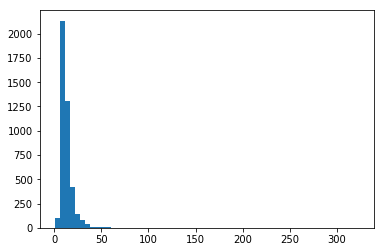

In [5]:
plt.hist(df_profits[df_profits['popularity'] > 0]['popularity'], bins=60);
plt.show()

## What's the range of average vote ratings?

/Users/chrischung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    4273.000000
mean        6.540417
std         0.832336
min         2.600000
25%         6.000000
50%         6.500000
75%         7.100000
max         8.800000
Name: vote_average, dtype: float64

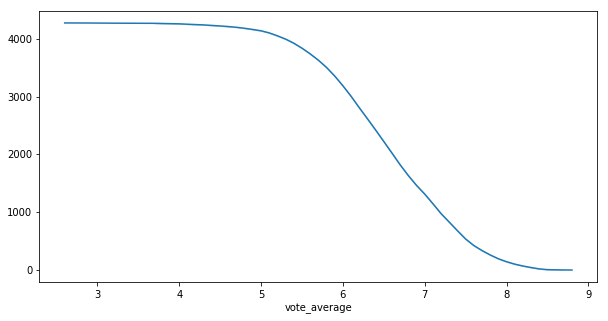

In [6]:
y = range(0, df_profits['title'].count()) # plotting movie vote_average
x = df_profits['vote_average']
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x,y);

x.describe() 

It looks like most of our data is under 7

## Plotting gross profit vs vote average

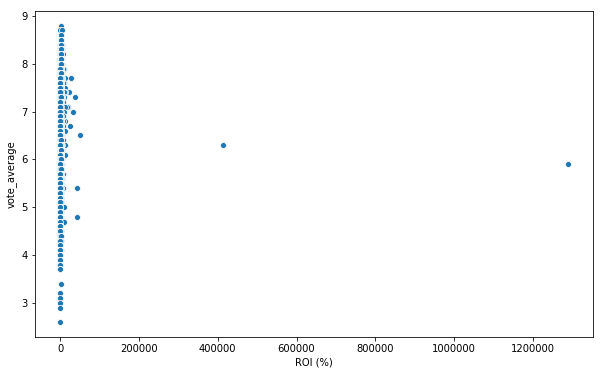

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df_profits['ROI (%)'], df_profits['vote_average']);

# the majority of movies making money have an average rating 5.5 - 8.5 (estimated)

## Plotting gross profit vs vote count

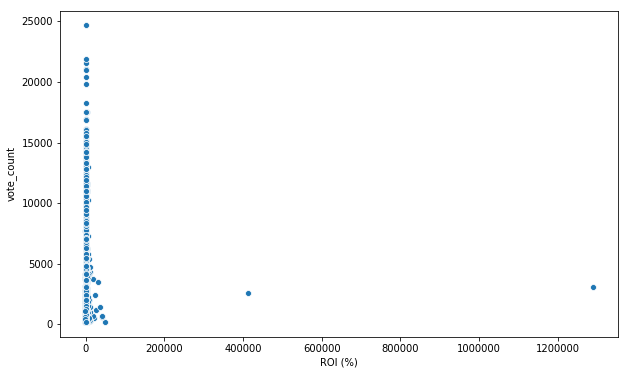

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df['ROI (%)'], df['vote_count'])

# there is positive correlation between gross_profit and vote_count
# more vote counts more money

## Plotting profit vs popularity

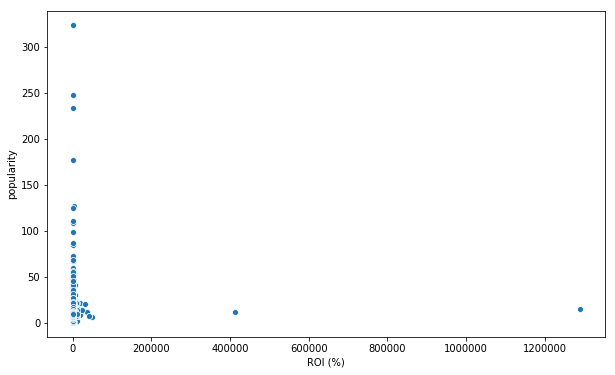

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df_profits['ROI (%)'], df_profits['popularity'])

#isn't much correlation 

In [10]:
type(df['genres'][0].strip('[').strip(']'))

str

In [11]:
genre_count_list = []
pd.DataFrame(df['genres']).iloc[0]
# so far each entry is made up of strings

df['genres'].value_counts() # maybe we can see for each genres 

['Comedy']                                                          552
['Drama']                                                           419
['Drama', 'Romance']                                                195
['Comedy', 'Romance']                                               176
['Comedy', 'Drama']                                                 173
['Horror', 'Thriller']                                              140
['Comedy', 'Drama', 'Romance']                                      124
['Horror']                                                          121
['Drama', 'Thriller']                                                80
['Drama', 'Comedy']                                                  76
['Drama', 'History']                                                 70
['Action', 'Thriller']                                               67
['Thriller']                                                         61
['Crime', 'Drama', 'Thriller']                                  

In [12]:
df[df['gross_profit'] > 1000000000]['genres'].value_counts()

['Action', 'Adventure', 'Science Fiction']                3
['Action', 'Adventure', 'Fantasy', 'Science Fiction']     2
['Action', 'Adventure', 'Animation', 'Family']            1
['Adventure', 'Action', 'Science Fiction']                1
['Drama', 'Romance', 'Thriller']                          1
['Adventure', 'Fantasy', 'Action']                        1
['Action', 'Thriller']                                    1
['Family', 'Fantasy', 'Romance']                          1
['Adventure', 'Family']                                   1
['Adventure', 'Science Fiction', 'Action']                1
['Action', 'Adventure', 'Science Fiction', 'Thriller']    1
['Action', 'Adventure', 'Science Fiction', 'Fantasy']     1
['Fantasy', 'Adventure']                                  1
['Crime', 'Thriller', 'Drama']                            1
['Animation', 'Family', 'Adventure']                      1
['Family', 'Animation', 'Adventure', 'Comedy']            1
['Animation', 'Adventure', 'Family']    

In [13]:
df[df['ROI (%)'] > 1000]['genres'].value_counts()

['Horror']                                                24
['Drama']                                                 23
['Comedy']                                                22
['Horror', 'Thriller']                                    15
['Drama', 'Romance']                                      12
['Comedy', 'Drama']                                       10
['Comedy', 'Drama', 'Romance']                            10
['Adventure', 'Action', 'Thriller']                        8
['Comedy', 'Romance']                                      7
['Drama', 'Comedy']                                        6
['Western']                                                5
['Horror', 'Mystery', 'Thriller']                          4
['Thriller', 'Horror']                                     4
['Action', 'Crime', 'Thriller']                            3
['Horror', 'Drama', 'Thriller']                            3
['Comedy', 'Crime']                                        3
['Adventure', 'Action', 

In [14]:
# each movie you have has a profit_margin (ROI)
# you have 1 movie with a list of genres ['Action, Adventure','Fantasy'a]
# 657
df_profits.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%)
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0,657.58
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0,13.37
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0,3984.44
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0,1669.38
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0,1360.75


## Preprocess Data to Calculate Average Weighted Budget for Each Genre

In [16]:
import ast #one example

# turn string into a list of strings
df['genres'][0]
res = ast.literal_eval(df['genres'][0]) 

In [17]:
# Turn genre combination in string form to list form to get a count of each one
import ast #one example
from tqdm import tqdm

df_profits = df_profits.reset_index(drop=True)

res_list = [] #loop through
for i in df_profits['genres']:
    res = ast.literal_eval(i)
    res_list.append(res)

df_profits['genres'] = res_list
df_profits['genres']

0                                [Comedy, Drama, Romance]
1                                          [Drama, Crime]
2                                          [Drama, Crime]
3                               [Comedy, Thriller, Drama]
4                                   [Drama, History, War]
5                                          [Drama, Crime]
6                            [Animation, Family, Fantasy]
7                                 [Fantasy, Drama, Crime]
8                                       [Thriller, Crime]
9                                         [Comedy, Drama]
10                               [Comedy, Drama, Romance]
11                       [Drama, Action, Crime, Thriller]
12                           [Adventure, Fantasy, Action]
13                                        [Action, Drama]
14                                         [Drama, Crime]
15                                         [Drama, Crime]
16                              [Horror, Drama, Thriller]
17            

In [18]:
# count of all genres

genre_and_count ={}
for genres in df_profits.genres:
    for genre in genres:
        genre_and_count[genre] = genre_and_count.get(genre, 1) + 1 

In [19]:
print(sum(genres_count.values()))
genres_count

NameError: name 'genres_count' is not defined

In [ ]:
# graph of the number of genres
fig, ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
plt.bar(genres_count.keys(), genres_count.values());

## Calculate Average Weighted Budget for Each Genre

In [20]:
# get number of genres per row and divide it by the budget
df_profits['qty_of_genres'] = df_profits['genres'].map(lambda x: len(x)) # get len of each genre and create column
df_profits['weighted_budget']  = round(df_profits['budget'] / df_profits['qty_of_genres'],2) #divide budget/genre qty for weights

In [21]:
#sum the weighted budget for each genre to average it by the number of individual genres in next cell
genre_wbudget ={} 
for index in df_profits.index:
    for genre in df_profits['genres'][index]:
        budget = df_profits['weighted_budget'][index] 
        genre_wbudget[genre] = genre_wbudget.get(genre,0) + budget
genre_wbudget

{'Comedy': 22110244977.059982,
 'Drama': 21582787850.83,
 'Romance': 7335526459.839999,
 'Crime': 7571728193.84,
 'Thriller': 15334472643.820002,
 'History': 2506955968.609999,
 'War': 1780655075.23,
 'Animation': 5656756198.65,
 'Family': 9817419606.749998,
 'Fantasy': 10801039632.24,
 'Action': 24153247089.410004,
 'Adventure': 20642300959.53,
 'Horror': 4046237816.4299994,
 'Western': 768518730.49,
 'Science Fiction': 12089632379.579998,
 'Music': 893114061.4799999,
 'Mystery': 3848972922.3900003,
 'TV Movie': 2333333.33}

In [22]:
# get average of the weighted budget by genre count
genre_and_weight_budget = {}
for genre, budget in genre_wbudget.items():
    genre_and_weight_budget.update({genre:budget / genre_and_count[genre]})
genre_and_weight_budget 

{'Comedy': 14939354.714229718,
 'Drama': 11498555.061710177,
 'Romance': 10509350.228997134,
 'Crime': 10801324.099629102,
 'Thriller': 11961367.116864275,
 'History': 12989409.163782379,
 'War': 12113299.831496598,
 'Animation': 19778867.827447552,
 'Family': 19517732.816600394,
 'Fantasy': 20891759.443404254,
 'Action': 20195022.650008366,
 'Adventure': 22935889.955033332,
 'Horror': 7397144.088537476,
 'Western': 12198710.007777778,
 'Science Fiction': 20318709.881647054,
 'Music': 8425604.353584904,
 'Mystery': 9622432.305975001,
 'TV Movie': 1166666.665}

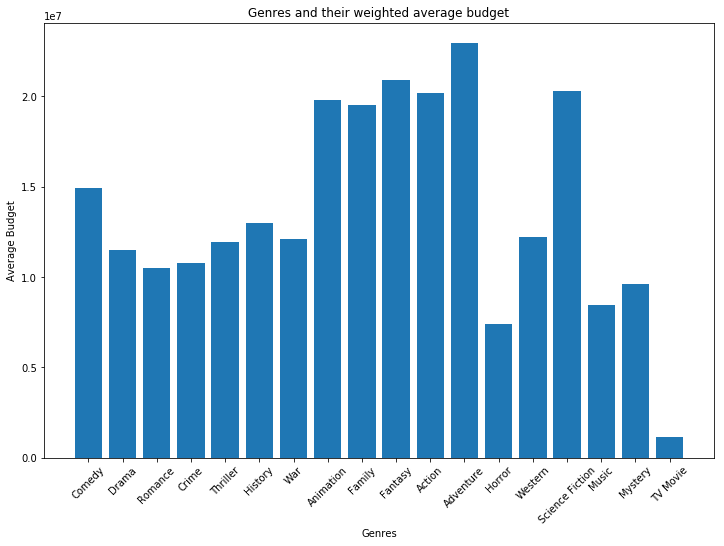

In [23]:
plt.figure(figsize=(12,8));
plt.bar(genre_and_weight_budget.keys(),genre_and_weight_budget.values());
plt.title('Genres and their weighted average budget');
plt.xlabel('Genres');
plt.ylabel('Average Budget');
plt.xticks(rotation=45)
plt.show()

## Calculate Average Weighted ROI for Each Genre

In [24]:
def reject_outliers(data, m=2):
    return data[abs(data['ROI (%)'] - np.mean(data['ROI (%)'])) < m * np.std(data['ROI (%)'])]

df_profits = reject_outliers(df_profits, m=2)
df_profits[df_profits['title'] == 'Paranormal Activity']

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%),qty_of_genres,weighted_budget


In [25]:
df_profits['weighted_ROI']  = round(df_profits['ROI (%)'] / df_profits['qty_of_genres'],2) #divide budget/genre qty for weights
# sum the weight
# sum the weight / qty

In [26]:
# trying to link genre to the ROI
genre_roi_sum = {}
for index in df_profits.index:
    for genre in df_profits['genres'][index]:
        roi = df_profits['weighted_ROI'][index] 
        genre_roi_sum[genre] = genre_roi_sum.get(genre,0) + roi    
genre_roi_sum

{'Comedy': 291352.6400000003,
 'Drama': 338942.69999999925,
 'Romance': 109076.81000000007,
 'Crime': 71423.08000000007,
 'Thriller': 170096.76,
 'History': 18970.109999999997,
 'War': 18500.899999999987,
 'Animation': 56267.310000000056,
 'Family': 73310.18000000008,
 'Fantasy': 53669.08000000004,
 'Action': 118984.74000000018,
 'Adventure': 98867.52000000014,
 'Horror': 273084.0800000001,
 'Western': 21461.239999999998,
 'Science Fiction': 65997.28000000006,
 'Music': 19758.770000000008,
 'Mystery': 44336.78999999998,
 'TV Movie': 9.05}

In [65]:
unique_genres = list(genre_roi_sum.keys())
unique_genres

['Comedy',
 'Drama',
 'Romance',
 'Crime',
 'Thriller',
 'History',
 'War',
 'Animation',
 'Family',
 'Fantasy',
 'Action',
 'Adventure',
 'Horror',
 'Western',
 'Science Fiction',
 'Music',
 'Mystery',
 'TV Movie']

In [27]:
genre_weighted_roi = {}
for genre, roi in genre_roi_sum.items():
    genre_weighted_roi.update({genre: roi / genre_and_count[genre]})
genre_weighted_roi

{'Comedy': 196.8598918918921,
 'Drama': 180.57682472029796,
 'Romance': 156.27050143266484,
 'Crime': 101.8874179743225,
 'Thriller': 132.68078003120127,
 'History': 98.29072538860102,
 'War': 125.85646258503392,
 'Animation': 196.73884615384634,
 'Family': 145.74588469184906,
 'Fantasy': 103.80866537717608,
 'Action': 99.48556856187307,
 'Adventure': 109.85280000000014,
 'Horror': 499.23963436928716,
 'Western': 340.65460317460315,
 'Science Fiction': 110.91979831932782,
 'Music': 186.40349056603782,
 'Mystery': 110.84197499999995,
 'TV Movie': 4.525}

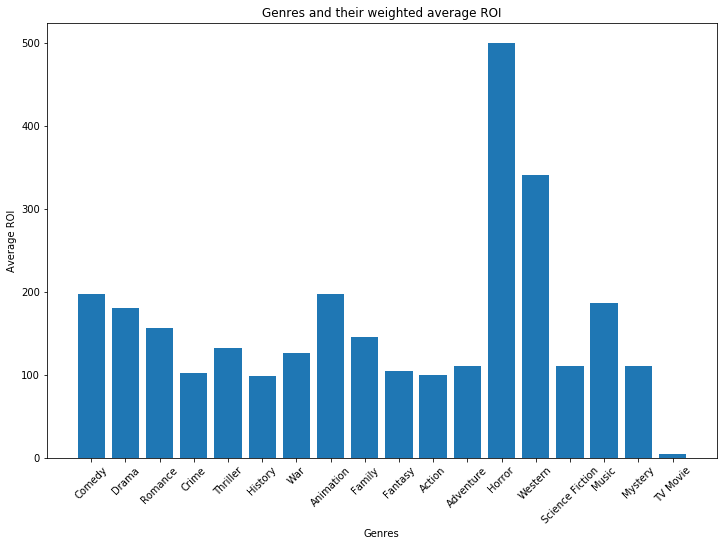

In [28]:
plt.figure(figsize=(12,8));
plt.bar(genre_weighted_roi.keys(),genre_weighted_roi.values());
plt.title('Genres and their weighted average ROI');
plt.xlabel('Genres');
plt.ylabel('Average ROI');
plt.xticks(rotation=45)
plt.show()

In [29]:
#we should turn the years into most recent so that we can give examples of excellent ROI
df_profits[df_profits['genres'].map(lambda x: 'Horror' in x)]['release_date']

16      1960-06-22
41      1991-02-01
69      1980-05-22
110     1979-05-25
147     1982-06-25
266     1968-06-12
332     2016-07-20
346     2019-10-18
350     1968-10-01
385     1973-12-26
387     1933-03-15
409     1975-06-18
420     1960-04-06
431     2010-12-03
435     2014-06-19
436     1975-08-14
438     1977-03-19
443     1987-03-13
450     2001-08-02
471     2011-08-17
485     1935-04-20
491     2004-04-09
495     2017-02-24
499     1978-09-02
514     2008-01-26
517     1931-11-21
520     1963-03-28
560     2013-03-20
609     1992-08-13
622     1967-10-26
           ...    
4179    1989-07-28
4183    2000-12-22
4184    2017-09-01
4187    1998-04-10
4190    2014-12-04
4192    2016-05-13
4197    2015-07-24
4200    2007-03-09
4202    2012-01-06
4203    2000-09-22
4208    1996-08-23
4211    2001-07-24
4218    2013-02-28
4219    2011-03-16
4220    1977-06-17
4221    2014-01-08
4224    2002-07-01
4228    2007-09-06
4232    2015-05-15
4233    1983-03-16
4238    2012-08-23
4241    1993

In [30]:
df_profits[df_profits['genres'].map(lambda x: 'Thriller' in x)]

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%),qty_of_genres,weighted_budget,weighted_ROI
3,11363000,"[Comedy, Thriller, Drama]",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,1.896920e+08,1669.38,3,3787666.67,556.46
8,8000000,"[Thriller, Crime]",680,tt0110912,28.749,1994-09-10,214179088,154.0,Pulp Fiction,8.5,17548,2.061791e+08,2577.24,2,4000000.00,1288.62
11,185000000,"[Drama, Action, Crime, Thriller]",155,tt0468569,29.006,2008-07-16,1004558444,152.0,The Dark Knight,8.4,21095,8.195584e+08,443.00,4,46250000.00,110.75
16,806948,"[Horror, Drama, Thriller]",539,tt0054215,20.776,1960-06-22,32000000,109.0,Psycho,8.4,5795,3.119305e+07,3865.56,3,268982.67,1288.52
31,1000000,"[Drama, Mystery, Thriller]",567,tt0047396,16.146,1954-09-01,36764313,112.0,Rear Window,8.3,3399,3.576431e+07,3576.43,3,333333.33,1192.14
38,33000000,"[Crime, Mystery, Thriller]",807,tt0114369,26.038,1995-09-22,327311859,127.0,Se7en,8.3,12154,2.943119e+08,891.85,3,11000000.00,297.28
40,8575000,"[Thriller, Drama, Romance]",290098,tt4016934,18.022,2016-06-01,37767206,145.0,The Handmaiden,8.3,1557,2.919221e+07,340.43,3,2858333.33,113.48
41,19000000,"[Crime, Drama, Thriller, Horror]",274,tt0102926,4.556,1991-02-01,272742922,119.0,The Silence of the Lambs,8.3,9658,2.537429e+08,1335.49,4,4750000.00,333.87
58,55000000,"[Crime, Thriller, Drama]",475557,tt7286456,98.211,2019-10-02,1073698955,122.0,Joker,8.2,9546,1.018699e+09,1852.18,3,18333333.33,617.39
59,2479000,"[Mystery, Romance, Thriller]",426,tt0052357,17.106,1958-05-09,28000000,128.0,Vertigo,8.2,2947,2.552100e+07,1029.49,3,826333.33,343.16


In [31]:
import datetime

In [32]:
df_profits['release_date'] = pd.to_datetime(df_profits['release_date'])

In [33]:
df_profits['release_year'] = df_profits['release_date'].map(lambda x: x.year)

In [34]:
df_profits.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'gross_profit', 'ROI (%)', 'qty_of_genres', 'weighted_budget',
       'weighted_ROI', 'release_year'],
      dtype='object')

In [55]:
horror_df = df_profits[df_profits['genres'].map(lambda x: 'Horror' in x)].groupby('release_year').mean().reset_index()
horror_df[(horror_df['release_year'] >= 2010) & (horror_df['release_year'] <= 2020)].reset_index()[['release_year','weighted_budget','weighted_ROI']]

,release_year,weighted_budget,weighted_ROI
0,2010,5.436508e+06,416.572381
1,2011,7.565490e+06,206.916818
2,2012,7.594444e+06,521.085556
3,2013,9.357778e+06,339.509333
4,2014,4.249667e+06,873.605217
5,2015,5.504412e+06,368.082353
6,2016,4.236988e+06,158.285185
7,2017,1.003826e+07,346.065000
8,2018,7.259058e+06,281.626522
9,2019,9.388021e+06,221.756875


In [62]:
def genre_year(df, genre):
    genre_df = df[df['genres'].map(lambda x: genre in x)].groupby('release_year').mean().reset_index()
    a = genre_df[(genre_df['release_year'] >= 2010) & (genre_df['release_year'] <= 2020)].reset_index()[['release_year','weighted_budget','weighted_ROI']]
    list_of_genres =[]
    for i in range(len(a)):
        list_of_genres.append(genre)
        
    a['genre'] = list_of_genres
    return a

In [82]:
genre_year(df_profits,'Horror')

,release_year,weighted_budget,weighted_ROI,genre
0,2010,5.436508e+06,416.572381,Horror
1,2011,7.565490e+06,206.916818,Horror
2,2012,7.594444e+06,521.085556,Horror
3,2013,9.357778e+06,339.509333,Horror
4,2014,4.249667e+06,873.605217,Horror
5,2015,5.504412e+06,368.082353,Horror
6,2016,4.236988e+06,158.285185,Horror
7,2017,1.003826e+07,346.065000,Horror
8,2018,7.259058e+06,281.626522,Horror
9,2019,9.388021e+06,221.756875,Horror


In [88]:
profit_genre_by_year =  [genre_year(df_profits, genre) for genre in unique_genres]
profit_genres_by_year = pd.concat(chris)
profit_genres_by_year

,release_year,weighted_budget,weighted_ROI,genre
0,2010,1.937623e+07,94.586719,Comedy
1,2011,1.740754e+07,123.458714,Comedy
2,2012,1.984924e+07,127.370877,Comedy
3,2013,1.804717e+07,173.004717,Comedy
4,2014,1.462440e+07,142.465000,Comedy
5,2015,1.528987e+07,150.708500,Comedy
6,2016,1.594691e+07,122.331286,Comedy
7,2017,2.018966e+07,110.886667,Comedy
8,2018,1.719528e+07,129.458333,Comedy
9,2019,1.782863e+07,100.365000,Comedy


In [42]:
group_by_year = df_profits.groupby('release_year').sum().reset_index()

In [46]:
group_by_year[(group_by_year['release_year'] >= 2010) & (group_by_year['release_year'] <= 2020)]

,release_year,budget,id,popularity,revenue,runtime,vote_average,vote_count,gross_profit,ROI (%),qty_of_genres,weighted_budget,weighted_ROI
79,2010,8095570778,6037549,2105.975,22489392569,18094.0,1083.4,375197,1.439382e+10,46483.28,467,3.142750e+09,21943.45
80,2011,8450845585,10682550,2185.475,23876741332,19758.0,1172.0,386316,1.542590e+10,50451.12,487,3.277967e+09,28391.28
81,2012,7764460420,12482924,1989.049,24647345063,16995.0,997.2,420107,1.688288e+10,46866.93,417,3.062944e+09,23155.98
82,2013,8691516653,22726818,2287.988,25112115828,20212.0,1181.9,493681,1.642060e+10,40496.08,456,3.460936e+09,20923.64
83,2014,7685468000,36498362,2691.294,25668300471,20180.0,1200.9,522336,1.798283e+10,58616.67,439,3.036001e+09,38208.68
84,2015,7409096577,44609506,2449.011,26625451912,19239.0,1118.2,464275,1.921636e+10,54812.46,454,2.828400e+09,24705.36
85,2016,9071768279,59576540,2533.157,28640201018,21606.0,1271.7,534648,1.956843e+10,46819.95,525,3.305866e+09,22316.02
86,2017,7479694802,51598835,2194.565,27586973183,16505.0,956.4,460388,2.010728e+10,47373.87,396,2.719281e+09,19721.46
87,2018,6816779171,56768709,2232.190,24936524209,15091.0,892.8,322672,1.811975e+10,61137.98,361,2.739259e+09,25648.15
88,2019,6223232016,41663915,3683.953,24010133291,10831.0,621.9,177547,1.778690e+10,31381.42,262,2.315784e+09,12506.75


ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c = 0              Comedy
1              Comedy
2              Comedy
3              Comedy
4              Comedy
5              Comedy
6              Comedy
7              Comedy
8              Comedy
9              Comedy
10             Comedy
0               Drama
1               Drama
2               Drama
3               Drama
4               Drama
5               Drama
6               Drama
7               Drama
8               Drama
9               Drama
0             Romance
1             Romance
2             Romance
3             Romance
4             Romance
5             Romance
6             Romance
7             Romance
8             Romance
           ...       
0     Science Fiction
1     Science Fiction
2     Science Fiction
3     Science Fiction
4     Science Fiction
5     Science Fiction
6     Science Fiction
7     Science Fiction
8     Science Fiction
9     Science Fiction
10    Science Fiction
0               Music
1               Music
2               Music
3               Music
4               Music
5               Music
6               Music
7               Music
8               Music
0             Mystery
1             Mystery
2             Mystery
3             Mystery
4             Mystery
5             Mystery
6             Mystery
7             Mystery
8             Mystery
9             Mystery
Name: genre, Length: 176, dtype: object.

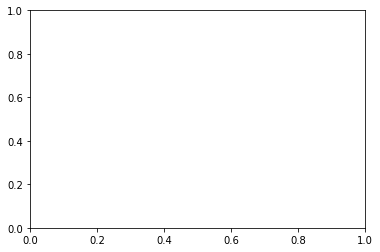

In [109]:
plt.scatter(x=profit_genres_by_year['release_year'],y=profit_genres_by_year['weighted_ROI'],b
            

In [111]:
import numpy as np
import pandas as pd
import plotly.express as px

# sample time series data
# np.random.seed(123)
# df = pd.DataFrame(np.random.randint(-10,12,size=(50, 4)), columns=list('ABCD'))
# datelist = pd.date_range(pd.datetime(2020, 1, 1).strftime('%Y-%m-%d'), periods=50).tolist()
# df['dates'] = datelist 
# df = df.set_index(['dates'])
# df.index = pd.to_datetime(df.index)
# df.iloc[0]=0
# df=df.cumsum().reset_index()

# # melt data to provide the data structure mentioned earlier
# dfm=pd.melt(df, id_vars=['dates'], value_vars=df.columns[1:])
# dfm.set_index('dates')
# dfm.head()

# plotly
fig = px.line(profit_genres_by_year, x="release_year", y="weighted_ROI", color='genre')
fig.show()

ModuleNotFoundError: No module named 'plotly.express'